# Snakes and Sequences: Senegalese Serpent Venom Sequencing Hackathon


<figure>
<center>
<img src='https://ideogram.ai/assets/image/lossless/response/OSUbpH_nTg6_IHiRw-9YPg' />
</figure>

## **The Task: recalibrating model predictions**

How can we help? In this hackathon we will be improving existing _de novo_ peptide sequencing models. Specifically, we will be looking into recalibration and filtering! Rather than training a large _de novo_ sequencing model from scratch, we will focus on using various techniques to improve the area under the curve (AUC) for the precision-recall graph. Due to high noise, our models are often not super well calibrated.

InstaDeep has developed a transformer-based _de novo_ peptide sequencing model **InstaNovo** [[preprint](https://www.biorxiv.org/content/10.1101/2023.08.30.555055v3)][[code](https://github.com/instadeepai/InstaNovo)].
We will provide you with the inputs AND outputs of InstaNovo along with some additional metadata (eg. retention time). The InstaNovo outputs includes the top 5 beam predictions along with their model confidences.
Your task is to use these inputs and metadata to re-calibrate the confidence measurements and filter out any false positives in order to maximise the AUC!

### **OUR APPROACH**

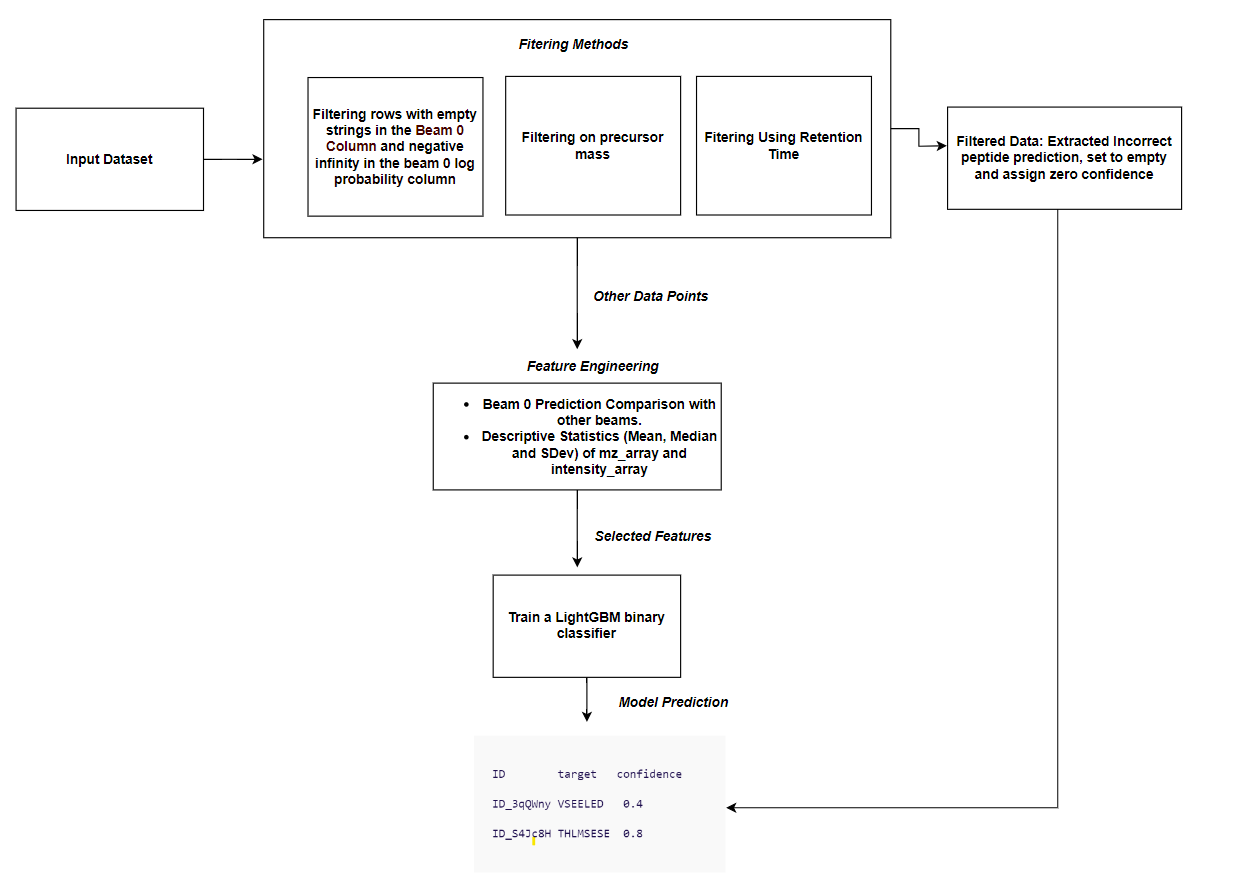

## **SETUP**

Connect Google Drive to Colab. The Datasets have been upload to our drive repository [here]()

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

### **Install and Load Dependencies**

Install relevant Libraries needed for the solution and Load the dependencies.

In [ ]:
# %%capture
!pip install catboost==1.2.6
!pip install lightgbm==4.4.0
!pip install xgboost==2.1.1
!pip install sklearn==1.3.2
!pip install koinapy

In [ ]:
import catboost
import lightgbm as lgb
import xgboost
import sklearn
import koinapy

import bisect
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

import warnings

warnings.filterwarnings("ignore")

print(catboost.__version__)
print(lgb.__version__)
print(xgboost.__version__)
print(sklearn.__version__)

## **Config**

In [ ]:
class CFG:
    data_path = "data"  # "/content/drive/MyDrive/Indaba-Hack/Instadeep/"

    tokenizer_regex = r"(\([^)]+\))|([A-Z](?:\([^)]+\))?)"

    PROTON_MASS_AMU = 1.007276
    H2O_MASS = 18.0106

## **UTILS**

In [ ]:
# Amino acid masses
residue_masses = {
    "G": 57.021464,
    "A": 71.037114,
    "S": 87.032028,
    "P": 97.052764,
    "V": 99.068414,
    "T": 101.047670,
    "C": 103.009185,
    "L": 113.084064,  # Beware!
    "I": 113.084064,  # Mass of Isoleucine and Leucine are the same!
    "N": 114.042927,
    "D": 115.026943,
    "Q": 128.058578,
    "K": 128.094963,
    "E": 129.042593,
    "M": 131.040485,
    "H": 137.058912,
    "F": 147.068414,
    "R": 156.101111,
    "Y": 163.063329,
    "W": 186.079313,
    # Post-translational modifications
    "M(+15.99)": 147.035400,  # Oxidation
    "C(+57.02)": 160.030649,  # Cysteine alkylation
    "N(+.98)": 115.026943,  # Deamidation
    "Q(+.98)": 129.042594,  # Deamidation
    "S(+79.97)": 166.998028,  # Phosphorylation
    "T(+79.97)": 181.01367,  # Phosphorylation
    "Y(+79.97)": 243.029329,  # Phosphorylation
}

In [ ]:
def tokenize(sequence: str) -> list[str]:
    """Split a peptide represented as a string into a list of residues.

    Args:
        sequence (str): The peptide to be split.

    Returns:
        list[str]: The sequence of residues forming the peptide.
    """
    return [
        item
        for sublist in re.findall(CFG.tokenizer_regex, sequence)
        for item in sublist
        if item
    ]


def get_sequence_mass(sequence: list[str], charge: int | None) -> float:
    """Get the mass of a sequence.

    Args:
        sequence (list[str]):
            The residue sequence whose mass to calculate.
            All residues must be in residue_masses or
            this will raise a `KeyError`.
        charge (int | None, optional):
            Charge of the sequence to calculate the mass.

    Returns:
        float: The mass of the sequence in Daltons.
    """
    mass = sum([residue_masses[residue] for residue in sequence]) + CFG.H2O_MASS
    if charge:
        mass = (mass / charge) + CFG.PROTON_MASS_AMU
    return float(mass)

In [ ]:
def get_theoretical_spectrum(sequence):
    """Calculate theoretical y- and b- ions of a peptide."""
    if isinstance(sequence, str):
        sequence = tokenize(sequence)
    substrings = [sequence[: i + 1] for i in range(len(sequence))][:-1]
    reverse_substrings = [sequence[i:] for i in range(len(sequence))][1:]
    b_ions = [get_sequence_mass(x, charge=1) for x in substrings]
    y_ions = [get_sequence_mass(x, charge=1) for x in reverse_substrings]
    return np.concatenate([np.array(b_ions) - CFG.H2O_MASS, np.array(y_ions)])


def get_num_match(sequence, mz_array, tolerance=0.4):
    """Calculate the number of matching peaks."""
    experimental_spectrum = np.array(mz_array)
    theoretical_spectrum = np.array(get_theoretical_spectrum(sequence))
    differences = np.abs(experimental_spectrum[:, None] - theoretical_spectrum)

    # Count the number of experimental peaks that have at least one matching theoretical peak
    num_match = np.sum(np.any(differences < tolerance, axis=1))

    return num_match

In [ ]:
## Improved theoretical spectrum with Prosit


def map_modification(peptide):
    mapping = {
        # Prosit uses a different notation for these modifications
        "M(+15.99)": "M[UNIMOD:35]",
        "C(+57.02)": "C[UNIMOD:4]",
        # Deamidation not supported by Prosit
        "N(+.98)": "N",
        "Q(+.98)": "Q",
        # Phosphorylation not supported by Prosit
        "S(+79.97)": "S",
        "T(+79.97)": "T",
        "Y(+79.97)": "Y",
    }
    return [mapping[residue] if residue in mapping else residue for residue in peptide]

In [ ]:
def compute_ion_identifications(
    dataset: pd.DataFrame, source_column: str, mz_tolerance: float
):
    matches = [
        find_matching_ions(
            source_mz=row[source_column],
            target_mz=row["mz_array"],
            target_intensities=row["intensity_array"],
            mz_tolerance=mz_tolerance,
        )
        for _, row in dataset.iterrows()
    ]
    return zip(*matches)


def find_matching_ions(
    source_mz: list[float],
    target_mz: list[float],
    target_intensities: list[float],
    mz_tolerance: float,
) -> tuple[list[float], list[float]]:
    try:
        num_matches, match_intensity = 0, 0.0
        for ion_mz in source_mz:
            nearest = bisect.bisect_left(target_mz, ion_mz)
            if nearest < len(target_mz):
                if target_mz[nearest] - ion_mz < mz_tolerance:
                    num_matches += 1
                    match_intensity += target_intensities[nearest]
                    continue
            if nearest > 0:
                if ion_mz - target_mz[nearest - 1] < mz_tolerance:
                    num_matches += 1
                    match_intensity += target_intensities[nearest - 1]
        return num_matches / len(source_mz), match_intensity / sum(target_intensities)
    except TypeError:
        print(source_mz)


def compute_prosit_features(mz_tolerance: float, dataset: pd.DataFrame) -> pd.DataFrame:
    inputs = pd.DataFrame()
    inputs["peptide_sequences"] = np.array(
        ["".join(peptide) for peptide in dataset["prediction"].apply(map_modification)]
    )
    inputs["precursor_charges"] = np.array(dataset["precursor_charge"])
    inputs["collision_energies"] = np.array(len(dataset) * [25])

    predictions: pd.DataFrame = model.predict(inputs, debug=True)
    predictions["Index"] = predictions.index

    grouped_predictions = predictions.groupby(by="Index").agg(
        {
            "peptide_sequences": "first",
            "precursor_charges": "first",
            "collision_energies": "first",
            "intensities": list,
            "mz": list,
            "annotation": list,
        }
    )
    grouped_predictions["intensities"] = grouped_predictions.apply(
        lambda row: np.array(row["intensities"])[np.argsort(row["mz"])].tolist(), axis=1
    )
    grouped_predictions["annotation"] = grouped_predictions.apply(
        lambda row: np.array(row["annotation"])[np.argsort(row["mz"])].tolist(), axis=1
    )
    grouped_predictions["mz"] = grouped_predictions["mz"].apply(np.sort)
    dataset["prosit_mz"] = grouped_predictions["mz"]
    dataset["prosit_intensity"] = grouped_predictions["intensities"]

    ion_matches, match_intensity = compute_ion_identifications(
        dataset=dataset, source_column="prosit_mz", mz_tolerance=mz_tolerance
    )
    dataset["ion_matches"] = ion_matches
    dataset["ion_match_intensity"] = match_intensity
    return dataset

In [ ]:
# We increased the max_isotope_error to value of 2!
max_isotope_error = 2
CARBON_MASS_DELTA = 1.00335


def _calc_mass_error(
    mz_theoretical: float, mz_measured: float, charge: int, isotope: int = 0
) -> float:
    """Calculate the mass error between theoretical and actual mz in ppm."""
    return float(
        (mz_theoretical - (mz_measured - isotope * CARBON_MASS_DELTA / charge))
        / mz_measured
        * 10**6
    )


def _mass(seq: str | list[str], charge: int | None = None) -> float:
    """Calculate a peptide's mass or m/z."""
    if isinstance(seq, str):
        seq = tokenize(seq)
    return get_sequence_mass(seq, charge)


def matches_precursor(
    seq: str | list[str],
    prec_mass: float,
    prec_charge: int,
    prec_tol: int = 50,
) -> tuple[bool, list[float]]:
    """Check if a sequence matches the precursor mass within some tolerance."""
    seq_mass = _mass(seq, charge=prec_charge)
    delta_mass_ppm = [
        _calc_mass_error(seq_mass, prec_mass, prec_charge, isotope)
        for isotope in range(0, max_isotope_error + 1)
    ]
    return any(abs(d) < prec_tol for d in delta_mass_ppm), delta_mass_ppm

## **Dataset**

In [ ]:
# Initialize model
model = koinapy.Koina("Prosit_2020_intensity_HCD", "koina.wilhelmlab.org:443")

In [ ]:
train_df = pd.read_csv(f"{CFG.data_path}Train.csv", na_filter="")
test_df = pd.read_csv(f"{CFG.data_path}Test.csv", na_filter="")

## **Filter: Step 1 [Filtering Empty beam_zero prediction]**

In [ ]:
# Calculate whether it matches precursor for all beams
for i in range(5):
    train_df[f"delta_ppm_{i}"] = np.array(
        [
            # Find lowest ppm for all isotopes
            np.min(
                np.abs(
                    matches_precursor(
                        row[f"preds_beam_{i}"],
                        row["precursor_mz"],
                        row["precursor_charge"],
                        prec_tol=18,
                    )[1]
                )
            )
            if len(row[f"preds_beam_{i}"]) > 0
            else np.inf
            for _, row in train_df.iterrows()
        ]
    )


for i in range(5):
    test_df[f"delta_ppm_{i}"] = np.array(
        [
            # Find lowest ppm for all isotopes
            np.min(
                np.abs(
                    matches_precursor(
                        row[f"preds_beam_{i}"],
                        row["precursor_mz"],
                        row["precursor_charge"],
                        prec_tol=18,
                    )[1]
                )
            )
            if len(row[f"preds_beam_{i}"]) > 0
            else np.inf
            for _, row in test_df.iterrows()
        ]
    )

In [ ]:
[f"delta_ppm_{i}" for i in [1, 2, 3, 4]]

In [ ]:
ppm_tol = 11

preds = []
probs = []
for _, row in train_df.iterrows():
    pred = ""
    prob = -np.inf
    for i in range(5):
        if row[f"delta_ppm_{i}"] < ppm_tol:
            pred = row[f"preds_beam_{i}"]
            prob = row[f"log_probs_beam_{i}"]
            break
    preds.append(pred)
    probs.append(prob)


preds_test = []
probs_test = []
for _, row in test_df.iterrows():
    pred = ""
    prob = -np.inf
    for i in range(5):
        if row[f"delta_ppm_{i}"] < ppm_tol:
            pred = row[f"preds_beam_{i}"]
            prob = row[f"log_probs_beam_{i}"]
            break
    preds_test.append(pred)
    probs_test.append(prob)

In [ ]:
train_df["preds_beam_0"] = preds
train_df["log_probs_beam_0"] = probs

test_df["preds_beam_0"] = preds_test
test_df["log_probs_beam_0"] = probs_test

In [ ]:
(
    train_df[train_df["preds_beam_0"].apply(len) != 0].shape,
    train_df[train_df["preds_beam_0"].apply(len) == 0].shape,
)

In [ ]:
(
    test_df[test_df["preds_beam_0"].apply(len) != 0].shape,
    test_df[test_df["preds_beam_0"].apply(len) == 0].shape,
)

In [ ]:
## Beam Length

train_df["len_sequence"] = train_df["preds_beam_0"].map(lambda x: len(x))
test_df["len_sequence"] = test_df["preds_beam_0"].map(lambda x: len(x))

## Split Data
trainable_train_df = train_df[train_df["len_sequence"] > 0].reset_index(drop=True)
trainable_train_df["target"] = (
    trainable_train_df["preds_beam_0"] == trainable_train_df["target"]
) * 1

trainable_test_df = test_df[test_df["len_sequence"] > 0].reset_index(drop=True)
non_trainable_test_df = test_df[test_df["len_sequence"] == 0].reset_index(drop=True)

In [ ]:
trainable_train_df.shape, trainable_test_df.shape, non_trainable_test_df.shape

## **Method 2**: Filtering based on retention time

In [ ]:
test_df.shape

In [ ]:
trainable_test_df.shape

In [ ]:
import seaborn as sns

# Filter the data
filtered_data = trainable_train_df[trainable_train_df["exp_id"].eq("EXP_two56w")][
    "retention_time"
]

# Create the box plot
plt.figure(figsize=(8, 6))
sns.distplot(x=filtered_data)
plt.title("Box Plot of Retention Time for EXP_two56w")
plt.xlabel("Retention Time")
plt.show()

In [ ]:
for x in trainable_train_df["exp_id"].unique():
    a = trainable_train_df[trainable_train_df["exp_id"].eq(x)]["retention_time"]
    a = (a - a.min()) / (a.max() - a.min())

    mean = a.mean()
    min = a.min()
    max = a.max()
    median = a.median()

    print(
        f"ID: {x} ----  Mean: {mean} ---- Min: {min} ---- Max: {max} ---- Median: {median}"
    )

In [ ]:
for x in trainable_test_df["exp_id"].unique():
    a = trainable_test_df[trainable_test_df["exp_id"].eq(x)]["retention_time"]
    a = (a - a.min()) / (a.max() - a.min())

    mean = a.mean()
    min = a.min()
    max = a.max()
    median = a.median()

    print(
        f"ID: {x} ----  Mean: {mean} ---- Min: {min} ---- Max: {max} ---- Median: {median}"
    )

In [ ]:
# Create the box plot
plt.figure(figsize=(8, 6))
sns.distplot(x=a)
plt.title("Box Plot of Retention Time for EXP_two56w")
plt.xlabel("Retention Time")
plt.show()

In [ ]:
import pandas as pd


def filter_by_exp_id_and_retention_time(
    df, exp_id_column, retention_time_column, rt_tolerance=5, normalize=True
):
    # Group rows by the experiment ID (exp_id)
    grouped = df.groupby(exp_id_column)

    filtered_rows = []
    throw_away_rows = []

    # Iterate over each group of rows with the same exp_id
    for exp_id, group in grouped:
        # Calculate the median retention time for the group

        if normalize:
            min_rt = group[retention_time_column].min()
            max_rt = group[retention_time_column].max()

            ## Normalizing the retention group by experiment ID
            group[retention_time_column] = (group[retention_time_column] - min_rt) / (
                max_rt - min_rt
            )

        median_rt = group[retention_time_column].median()

        # Filter rows within the group based on retention time deviation from the median
        for _, row in group.iterrows():
            rt_diff = abs(row[retention_time_column] - median_rt)

            if rt_diff <= rt_tolerance:  # If within the tolerance, keep the row
                filtered_rows.append(row)
            else:
                throw_away_rows.append(row)

    # Convert the filtered rows back to a DataFrame
    filtered_df = pd.DataFrame(filtered_rows)
    throw_away_df = pd.DataFrame(throw_away_rows)

    # Return the filtered DataFrame

    return filtered_df.reset_index(drop=True), throw_away_df.reset_index(drop=True)

In [ ]:
tolerance_threshold = 35  # 0.5776

retained_train, throwout_train = filter_by_exp_id_and_retention_time(
    trainable_train_df,
    "exp_id",
    "retention_time",
    rt_tolerance=tolerance_threshold,
    normalize=False,
)  # 30

retained_test, throwout_test = filter_by_exp_id_and_retention_time(
    trainable_test_df,
    "exp_id",
    "retention_time",
    rt_tolerance=tolerance_threshold,
    normalize=False,
)  # 30

In [ ]:
retained_test.shape

## **Optimization of Confidence Scores with Machine learning**

#### **Model Setup**

- The task involves predicting peptide sequences, which are inherently categorical (i.e., sequences of amino acids). To simplify this, we reframed the problem as a binary classification task: **predicting whether each beam search prediction is correct or not**.

- For each beam search prediction (e.g., `preds_beam_0`, `preds_beam_1`, etc.), we created binary labels:
  - A label of `1` indicates that the prediction matches the actual target peptide.
  - A label of `0` indicates the prediction is incorrect.
  
  This transforms the peptide identification process into a supervised classification task, allowing us to train a model to determine the correctness of a given beam search prediction.

- We trained a **LightGBM classifier** to predict the probability that a refined beam search prediction (after multiple stages of filtration and correction) is the correct peptide. The model uses the refined predictions to **optimize the confidence scores** associated with each peptide, thereby improving the final peptide identification.

#### **What is the Objective here?**

The primary goal is to refine and improve the **confidence scores** assigned to each peptide prediction, ensuring that the most likely peptide is ranked higher. This probabilistic output from the classifier helps adjust the confidence levels for each candidate prediction, making the final peptide identification more accurate.




In [ ]:
# Preview the corrected training dataset
retained_train.head(2)

In [ ]:
# Preview the corrected test dataset
retained_test.head(2)

In [ ]:
# Correct the datatype of the mz_array and the intensity_arrays
retained_train["mz_array"] = retained_train["mz_array"].map(
    lambda x: list(map(float, re.findall(r"\d+\.\d*", x))) if isinstance(x, str) else x
)
retained_train["intensity_array"] = retained_train["intensity_array"].map(
    lambda x: list(map(float, re.findall(r"\d+\.\d*", x))) if isinstance(x, str) else x
)
retained_test["mz_array"] = retained_test["mz_array"].map(
    lambda x: list(map(float, re.findall(r"\d+\.\d+", x))) if isinstance(x, str) else x
)
retained_test["intensity_array"] = retained_test["intensity_array"].map(
    lambda x: list(map(float, re.findall(r"\d+\.\d*", x))) if isinstance(x, str) else x
)

**Feature Engineering**

In [ ]:
## Compare Beams
retained_train["beam_0_1"] = (
    retained_train["preds_beam_0"] == retained_train["preds_beam_1"]
) * 1
retained_train["beam_0_2"] = (
    retained_train["preds_beam_0"] == retained_train["preds_beam_2"]
) * 1
retained_train["beam_0_3"] = (
    retained_train["preds_beam_0"] == retained_train["preds_beam_3"]
) * 1
retained_train["beam_0_4"] = (
    retained_train["preds_beam_0"] == retained_train["preds_beam_4"]
) * 1


## Compare Beams
retained_test["beam_0_1"] = (
    retained_test["preds_beam_0"] == retained_test["preds_beam_1"]
) * 1
retained_test["beam_0_2"] = (
    retained_test["preds_beam_0"] == retained_test["preds_beam_2"]
) * 1
retained_test["beam_0_3"] = (
    retained_test["preds_beam_0"] == retained_test["preds_beam_3"]
) * 1
retained_test["beam_0_4"] = (
    retained_test["preds_beam_0"] == retained_test["preds_beam_4"]
) * 1

**Selecting Features for prediction**

In [ ]:
features = [
    "precursor_mz",
    "precursor_mass",
    "precursor_charge",
    "retention_time",
    "log_probs_beam_0",
    "delta_ppm_0",
    "len_sequence",
    "beam_0_1",
    "beam_0_2",
    "beam_0_3",
    "beam_0_4",
]

target = "target"

In [ ]:
array_columns = ["mz_array", "intensity_array"]
for columns in array_columns:
    retained_train[f"{columns}_mean"] = retained_train[columns].apply(
        lambda x: np.mean(x)
    )
    retained_train[f"{columns}_std"] = retained_train[columns].apply(
        lambda x: np.std(x)
    )
    retained_train[f"{columns}_median"] = retained_train[columns].apply(
        lambda x: np.median(x)
    )
    retained_train.drop(columns=columns, inplace=True)

    retained_test[f"{columns}_mean"] = retained_test[columns].apply(
        lambda x: np.mean(x)
    )
    retained_test[f"{columns}_std"] = retained_test[columns].apply(lambda x: np.std(x))
    retained_test[f"{columns}_median"] = retained_test[columns].apply(
        lambda x: np.median(x)
    )
    retained_test.drop(columns=columns, inplace=True)

Extract the names of the newly engineered features.

In [ ]:
new_col = []

for columns in array_columns:
    new_col.append(f"{columns}_mean")
    new_col.append(f"{columns}_std")
    new_col.append(f"{columns}_median")

Append the newly engineered features to the subset of features that we are interested in utilizing for predictions.

In [ ]:
train_feat = retained_train[features + new_col]
train_target = retained_train[target]

test_feat = retained_test[features + new_col]

Check distribution of the binary target (correct vs incorrect) predictions.

In [ ]:
train_target.value_counts()

#### **Data Splitting: Train and Validation Sets**

We split the initial training data into two: (A new training set and a validation set). [80:20]

In [ ]:
# Split the data with stratification by the target variable and drop the index
X_train, X_val, y_train, y_val = train_test_split(
    train_feat, train_target, test_size=0.2, stratify=train_target, random_state=42
)

# Reset index to drop the original index
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

Training the LightGBM Classifier

In [ ]:
import lightgbm as lgb

lgbm_model = lgb.LGBMClassifier(
    boosting_type="gbdt",
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=100,
    seed=47,
)

# Train the model
lgbm_model.fit(X_train, y_train)

**Predict and Evaluate on the validation set.**

In [ ]:
# Make predictions on the test set
y_pred = lgbm_model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_val, y_pred))

**Make Predictions on the test dataset.**

In [ ]:
new_probability = lgbm_model.predict_proba(test_feat)

**Extract the Probability/Confidence that a given row containing beam predictions from InstaNovo and properties of the peptide sequence is actually correct.**

In [ ]:
new_probability[:, 1]

**Feature Importance to Inspect the features that contribute the most to the updated confidence scores**

In [ ]:
# Print feature importance
importance_df = pd.DataFrame(
    {"feature": X_train.columns, "importance": lgbm_model.feature_importances_}
).sort_values(by="importance", ascending=False)

print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df["feature"], importance_df["importance"])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("LightGBM Feature Importance")
plt.gca().invert_yaxis()
plt.show()

## **Creating the Submission**

1. **Submission with Optimized Probabilities** [Top Solution selected on Public LB - CXRoitKf]

**Public LB:**

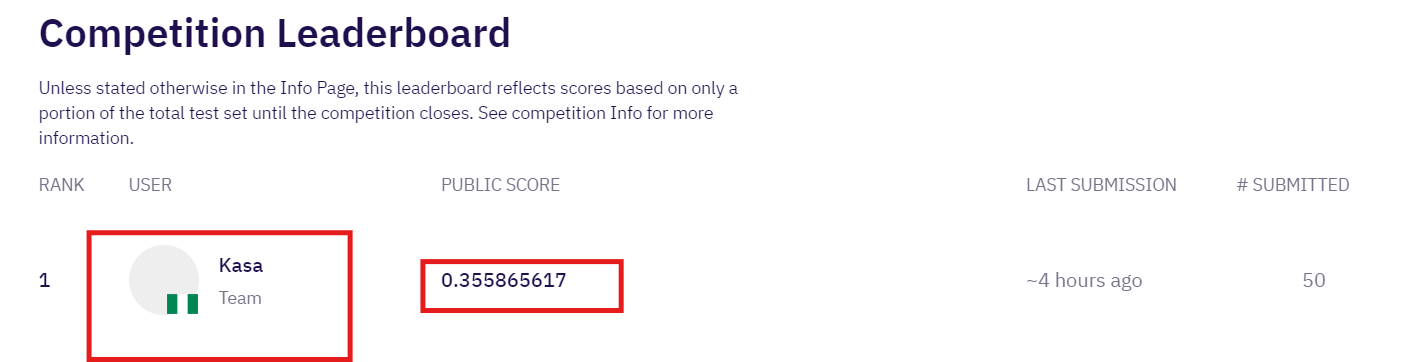

In [ ]:
## Filtering Stage 1
non_trainable_sub = pd.DataFrame(
    {
        "ID": non_trainable_test_df["ID"],
        "target": non_trainable_test_df["preds_beam_0"],
        "confidence": np.exp(non_trainable_test_df["log_probs_beam_0"]),
    }
)

## Filtering Stage 2
non_trainable_sub2 = pd.DataFrame(
    {
        "ID": throwout_test["ID"],
        "target": [""] * len(throwout_test["preds_beam_0"]),
        "confidence": [0] * len(throwout_test["preds_beam_0"]),
    }
)

## Filtering Stage 3
trainable_sub = pd.DataFrame(
    {
        "ID": retained_test["ID"],
        "target": retained_test["preds_beam_0"],
        "confidence": new_probability[:, 1],
    }
)

In [ ]:
final_submission = (
    pd.concat([non_trainable_sub, non_trainable_sub2, trainable_sub])
    .sample(frac=1)
    .reset_index(drop=True)
)
final_submission.to_csv("KASA_Instadeep_Winner_Solution_(With-ML).csv", index=False)